In [7]:
#CATBOOST - trening i wizualizacja, jak model działa

In [8]:
import optuna
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score, precision_score
from sklearn.model_selection import cross_val_score
import joblib
import shap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

df = pd.read_csv('learning_set.csv')
df.head()

# Zakładamy, że kolumna celu nazywa się:
target_column = 'Lung_Cancer_Diagnosis'

X = df.drop(columns=[target_column])
y = df[target_column]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    stratify=y,        # zachowujemy proporcje klas!
    random_state=42
)

def objective(trial):
    params = {
        "iterations": 1000,
        "learning_rate": 0.05,
        "scale_pos_weight": 20,
        "depth": trial.suggest_int("depth", 4, 6),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1.0, 10.0),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "random_strength": trial.suggest_float("random_strength", 0.0, 10.0),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "verbose": 0,
        "loss_function": 'Logloss',
        "eval_metric": 'Recall',  # Można też: 'Precision' / 'Recall' / 'F1'
        "random_state": 42,
    }

    model = CatBoostClassifier(**params)
    
    # używamy average_precision, bo lepiej działa na niezbalansowanych danych
    score = cross_val_score(model, X_train, y_train, cv=3, scoring="average_precision").mean()
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)#bo na razie nie mam czasu, a zaraz chce [przetestowac] co jak mi poszło

print("Best parameters:", study.best_params)


[I 2025-04-22 14:08:05,564] A new study created in memory with name: no-name-3d67b8d5-a317-45e9-bf40-e4ae078dbaee
[I 2025-04-22 14:08:39,677] Trial 0 finished with value: 0.06325659556389579 and parameters: {'depth': 5, 'l2_leaf_reg': 2.8402200829767588, 'bagging_temperature': 0.7637685941664579, 'random_strength': 2.9282310537548186, 'border_count': 254}. Best is trial 0 with value: 0.06325659556389579.
[I 2025-04-22 14:09:17,096] Trial 1 finished with value: 0.06047221739500739 and parameters: {'depth': 6, 'l2_leaf_reg': 2.3110456542116404, 'bagging_temperature': 0.49370699399320317, 'random_strength': 8.981548766217655, 'border_count': 102}. Best is trial 0 with value: 0.06325659556389579.
[I 2025-04-22 14:09:50,685] Trial 2 finished with value: 0.06301935283650899 and parameters: {'depth': 5, 'l2_leaf_reg': 9.006881571793429, 'bagging_temperature': 0.7880703420170456, 'random_strength': 3.725524626214848, 'border_count': 71}. Best is trial 0 with value: 0.06325659556389579.
[I 2025

Best parameters: {'depth': 4, 'l2_leaf_reg': 3.2054922301723288, 'bagging_temperature': 0.5985937960562558, 'random_strength': 4.014123864284676, 'border_count': 142}



🔍 Najlepszy threshold (na podstawie F2-score): 0.35
threshold    0.380000
precision    0.070034
recall       0.648287
f2           0.244511
Name: 28, dtype: float64


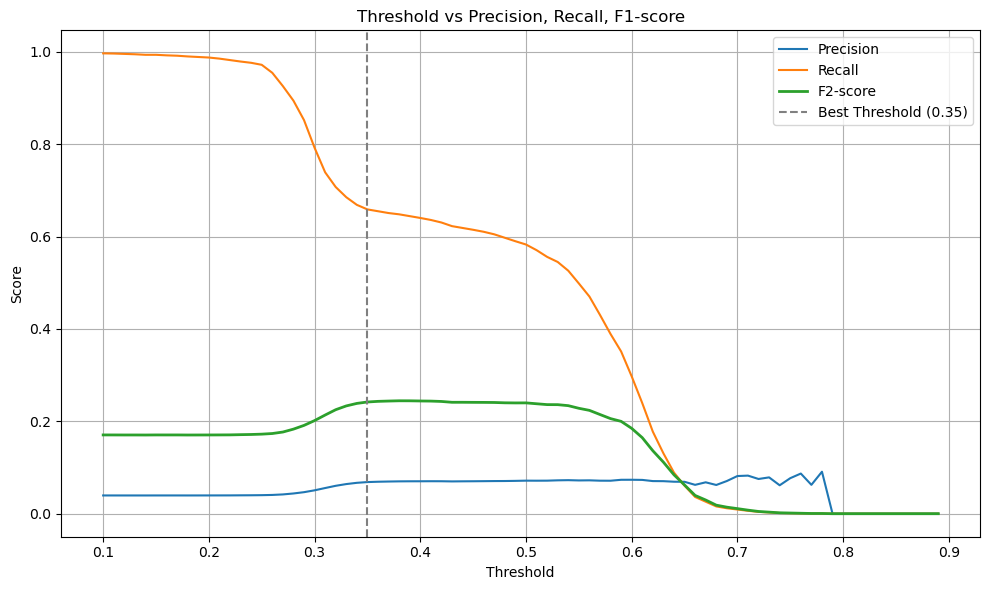

✅ Best threshold: 0.35 


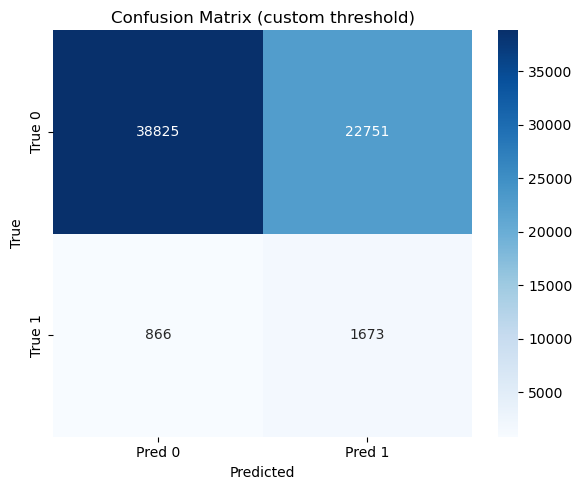

📊 Classification Report (custom threshold):
              precision    recall  f1-score   support

           0       0.98      0.63      0.77     61576
           1       0.07      0.66      0.12      2539

    accuracy                           0.63     64115
   macro avg       0.52      0.64      0.45     64115
weighted avg       0.94      0.63      0.74     64115

F1 Score: 0.1240959833846382
Precision (positive class): 0.0684981984932853


In [22]:
best_params = study.best_params
model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,
    scale_pos_weight=20,
    random_state=42,
    verbose=0,
    **best_params
)
model.fit(X_train, y_train)

# Predykcje prawdopodobieństw i dobór progu
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

# Przewidujemy prawdopodobieństwa
y_probs = model.predict_proba(X_test)[:, 1]

# Przygotowanie do optymalizacji progu
thresholds = np.arange(0.1, 0.9, 0.01)
results = []
from sklearn.metrics import fbeta_score

for thresh in thresholds:
    y_pred_thresh = (y_probs >= thresh).astype(int)
    precision = precision_score(y_test, y_pred_thresh, zero_division=0)
    recall = recall_score(y_test, y_pred_thresh, zero_division=0)
    f2 = fbeta_score(y_test, y_pred_thresh, beta=2, zero_division=0)
    results.append({'threshold': thresh, 'precision': precision, 'recall': recall, 'f2': f2})

# Konwertujemy wyniki do DataFrame
results_df = pd.DataFrame(results)

# Szukamy najlepszego progu
best_row = results_df.loc[results_df['f2'].idxmax()]
best_thresh = best_row['threshold']

#ponieważ działa to giga kiepsko
best_thresh = 0.35

print(f"\n🔍 Najlepszy threshold (na podstawie F2-score): {best_thresh:.2f}")
print(best_row)

# Rysujemy wykres
plt.figure(figsize=(10, 6))
plt.plot(results_df['threshold'], results_df['precision'], label='Precision')
plt.plot(results_df['threshold'], results_df['recall'], label='Recall')
plt.plot(results_df['threshold'], results_df['f2'], label='F2-score', linewidth=2)
plt.axvline(best_thresh, color='gray', linestyle='--', label=f'Best Threshold ({best_thresh:.2f})')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Threshold vs Precision, Recall, F1-score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


print(f"✅ Best threshold: {best_thresh:.2f} ")

# Ostateczna predykcja z najlepszym thresholdem
y_pred_final = (y_probs >= best_thresh).astype(int)
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test, y_pred_final)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Pred 0", "Pred 1"], yticklabels=["True 0", "True 1"])
plt.title("Confusion Matrix (custom threshold)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# Classification report
print("📊 Classification Report (custom threshold):")
print(classification_report(y_test, y_pred_final, digits=2))

print("F1 Score:", f1_score(y_test, y_pred_final))
print("Precision (positive class):", precision_score(y_test, y_pred_final))


In [23]:
import pickle
def save_model(model, path):
    with open(path, 'wb') as f:
        pickle.dump(model, f)

save_model(model, "models/catboost.pkl")


In [24]:
optuna.visualization.plot_optimization_history(study).show()
optuna.visualization.plot_param_importances(study).show()

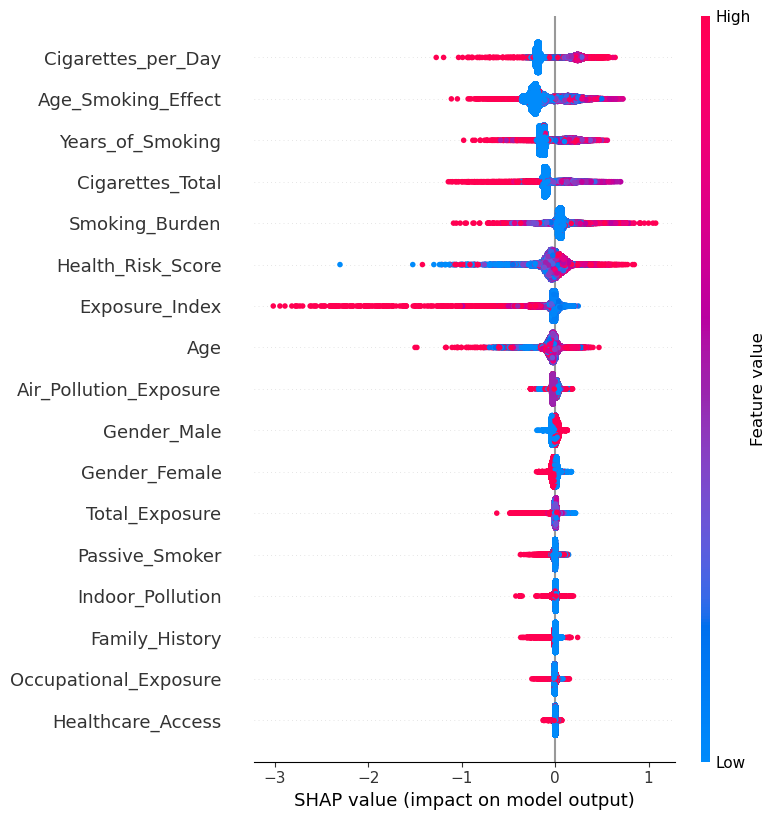

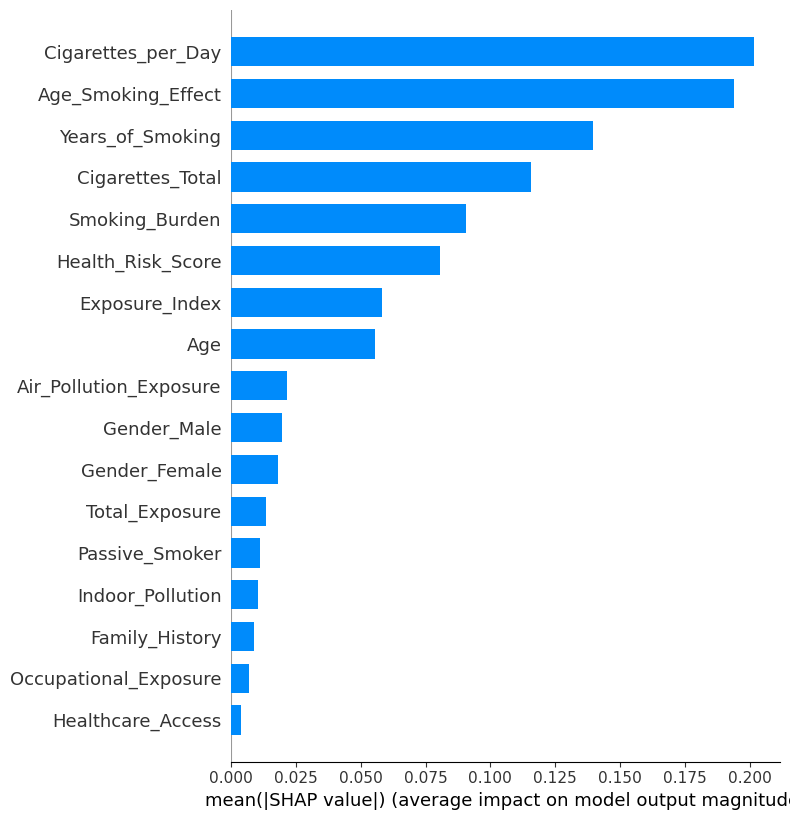

c:\Users\66891\anaconda3\Lib\site-packages\catboost\core.py:945: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



CatBoostError: catboost/libs/data/model_dataset_compatibility.cpp:72: Feature Years_of_Smoking is present in model but not in pool.

In [25]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Wykres ogólny
shap.summary_plot(shap_values, X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")
# Wykres dla pojedynczej próbki
shap.plots.waterfall(explainer(X_test.iloc[20]))  # <-- odkomentuj dla konkretnej obserwacji

